# Analyse instrumentée de trois types de sauts avec un accéléromètre Axivity AX3

Ce document présente l’analyse détaillée de trois types de sauts :

- un saut sans mouvement des bras  
- un saut avec mouvement des bras  
- un saut avec mouvement des bras associé à un élan  

L’accéléromètre Axivity AX3, fixé sur le corps, a enregistré l’accélération brute sur les axes X, Y et Z.

L’objectif de cette étude est d’extraire, caractériser et comparer les paramètres mécaniques associés à chaque type de saut, en utilisant une méthode standardisée appliquée sur les données issues de l'AX3.

Trois scripts ont été utilisés :

1. Visualisation simple du fichier RAW (Code 1)  
2. Détection locale de trois pics dans une fenêtre temporelle (Code 2)  
3. Pipeline complet d’analyse et d’extraction de métriques des trois sauts (Code 3)

Le présent rapport détaille le rôle de chaque code, les métriques extraites et l’interprétation des résultats.


# Code 1 — Visualisation brute du signal Z

Ce premier script a pour rôle d’inspecter visuellement le signal enregistré du 23 octobre 2025 comportant 6 sauts 
Il ne réalise ni filtrage, ni détection automatique, ni extraction de métriques.

## Objectifs du Code 1
- Charger les données enregistrées sans en-tête.  
- Convertir la première colonne en timestamp.  
- Tracer directement la composante Z sur toute la durée du fichier.

## Informations fournies
- Aperçu général de l’activité sur l’axe vertical (Z).  
- Repérage visuel des zones de saut.  
- Vérification rapide de l’intégrité des données.

## Limites
- Ne détecte aucun saut automatiquement.  
- Ne calcule aucune métrique (peak Z, prominence, RMS, norme).  
- Ne convertit pas les unités RAW en g.

Ce code est destiné exclusivement à l’exploration préliminaire des données.


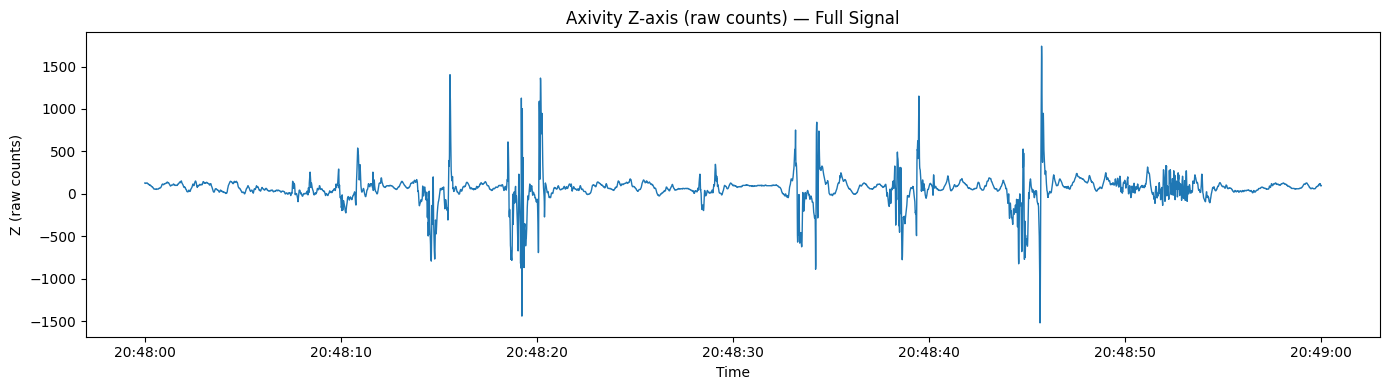

In [ ]:
# CODE 1 

import pandas as pd  # Import pandas for reading and handling tabular data
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Define the path to the RAW Axivity file (no header in this export)
FILE_PATH = "data/23_10_25_raw_cut.csv"  # Store file path as a constant

# Read the CSV file into a DataFrame with no header and explicit column names
df = pd.read_csv(  # Load the CSV file
    FILE_PATH,  # Use the file path defined above
    header=None,  # Indicate that the file has no header row
    names=["time", "x", "y", "z"],  # Manually assign column names
)

# Convert the time column from string to datetime objects
df["time"] = pd.to_datetime(df["time"])  # Parse timestamps into datetime format

# Create a new figure for the plot with a specific size
plt.figure(figsize=(14, 4))  # Initialize the figure (width 14 inches, height 4 inches)

# Plot the Z-axis raw acceleration over time
plt.plot(  # Draw the line plot
    df["time"],  # X-axis data - timestamps
    df["z"],  # Y-axis data - raw Z acceleration values
    linewidth=1,  # Set line thickness
)

# Add a title to the figure
plt.title("Axivity Z-axis (raw counts) - Full Signal")  # Title describing the plot

# Label the x-axis
plt.xlabel("Time")  # X-axis label

# Label the y-axis
plt.ylabel("Z (raw counts)")  # Y-axis label describing units

# Automatically adjust layout to avoid overlap
plt.tight_layout()  # Optimize spacing in the figure

# Display the figure
plt.show()  # Render the plot window


# Code 2 — Détection locale de trois pics sur le fichier du 23

Ce script effectue une extraction dans une fenêtre temporelle restreinte afin d’identifier trois pics verticaux dans un intervalle défini.

## Objectifs du Code 2
- Charger le fichier brut du 23 octobre.  
- Isoler une fenêtre temporelle précise (20:48:30 à 20:48:50).  
- Identifier les pics de l’axe Z au sein de cette fenêtre.  
- Regrouper les pics proches correspondant à un même saut.  
- Sélectionner les trois plus hauts pics Z.

## Méthode utilisée
- Estimation automatique de la fréquence d’échantillonnage.  
- Seuil adaptatif basé sur un quantile du signal (97%).  
- Détection de maxima locaux sur l’axe Z.  
- Regroupement des pics appartenant à la même impulsion.  
- Sélection des trois pics les plus élevés.

## Limites
- Ne calcule pas la norme de l’accélération.  
- Ne calcule pas la prominence.  
- Ne calcule pas les RMS de bras ou d’élan.  
- Ne correspond pas au protocole d’analyse utilisé pour la comparaison des trois sauts.  

Ce code sert uniquement à inspecter localement la structure du signal et à expérimenter une première détection.


3 peaks detected between 20:48:30 and 20:48:50:
   sample_index                    time  peak_z
0           437 2025-10-23 20:48:34.269   844.0
1           970 2025-10-23 20:48:39.475  1152.0
2          1610 2025-10-23 20:48:45.733  1740.0


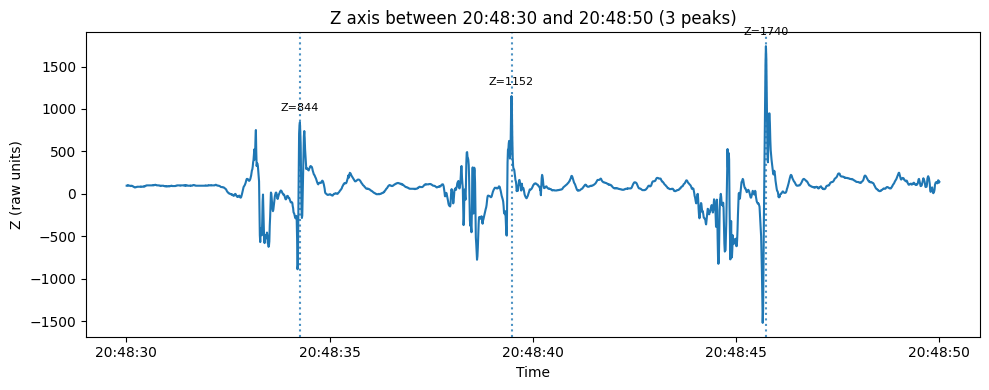

In [ ]:
# CODE 2

import pandas as pd  # Import pandas for data loading and manipulation
import numpy as np  # Import NumPy for numerical operations
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Define the path to the RAW Axivity file (no header in this export)
FILE_PATH = "data/23_10_25_raw_cut.csv"  # Store file path as a constant

# Read the RAW CSV into a DataFrame and skip Axivity comment lines
df = pd.read_csv(  # Load the CSV file
    FILE_PATH,  # Use the file path defined above
    sep=",",  # Specify comma as separator
    comment="#",  # Ignore metadata lines starting with '#'
    header=None,  # Indicate that the file has no header row
    names=["time", "x", "y", "z"],  # Manually assign column names
)

# Convert the time column to datetime and coerce invalid strings
df["time"] = pd.to_datetime(  # Parse timestamps
    df["time"],  # Take the time column
    errors="coerce",  # Turn invalid timestamps into NaT
)

# Remove rows where time could not be parsed and reset index
df = df.dropna(subset=["time"]).reset_index(drop=True)  # Keep only valid time rows

# Convert acceleration columns to floats for numerical processing
df[["x", "y", "z"]] = df[["x", "y", "z"]].astype(float)  # Cast raw values to float

# Define the start of the analysis window
start_time = pd.Timestamp("2025-10-23 20:48:30")  # Window start timestamp

# Define the end of the analysis window
end_time = pd.Timestamp("2025-10-23 20:48:50")  # Window end timestamp

# Extract only the samples within the window
segment = df[  # Create a filtered DataFrame
    (df["time"] >= start_time) & (df["time"] <= end_time)  # Boolean mask
].reset_index(drop=True)  # Reset index for clean plotting

# Ensure that the selected window contains data
if segment.empty:  # Check if the segment is empty
    raise ValueError("Window empty - check your timestamps.")  # Stop if no data found

# Compute time differences between consecutive samples in milliseconds
dt_ms = np.diff(segment["time"]).astype("timedelta64[ms]").astype(float)  # Delta t array

# Estimate the median sampling interval in seconds
dt_s = np.median(dt_ms) / 1000.0  # Convert ms to s using the median

# Estimate sampling frequency in Hz using the median interval
fs = int(round(1.0 / dt_s)) if dt_s > 0 else 100  # Fallback to 100 Hz if dt_s invalid

# Safety check for invalid frequency
if fs <= 0:  # If estimated frequency is non-positive
    fs = 100  # Use a reasonable default frequency

# Extract Z axis values as a NumPy array for speed
z = segment["z"].values  # Z acceleration inside the window

# Compute an adaptive threshold using the 97th percentile
z_threshold = np.quantile(z, 0.97)  # Keep only the strongest peaks

# Create a list to store candidate peak indices
candidate_peaks = []  # Initialize empty list for local maxima

# Loop through samples excluding the first and last
for i in range(1, len(z) - 1):  # Scan all internal points
    is_local_max = z[i] > z[i - 1] and z[i] > z[i + 1]  # Check local maximum
    is_above_thr = z[i] > z_threshold  # Check if above threshold
    if is_local_max and is_above_thr:  # Keep only strong local maxima
        candidate_peaks.append(i)  # Save peak index

# Define maximum allowed gap between peaks of the same jump
max_gap = int(0.8 * fs)  # Peaks closer than 0.8 s are grouped

# Create a list of clusters (each cluster corresponds to one jump)
clusters = []  # Initialize the cluster list

# Build clusters only if peaks exist
if candidate_peaks:  # Continue if at least one peak found
    current_cluster = [candidate_peaks[0]]  # Start first cluster with first peak
    for idx in candidate_peaks[1:]:  # Iterate over remaining peaks
        if idx - current_cluster[-1] < max_gap:  # If peak is close to previous
            current_cluster.append(idx)  # Add to current cluster
        else:  # If too far, close current cluster
            clusters.append(current_cluster)  # Store finished cluster
            current_cluster = [idx]  # Start a new cluster
    clusters.append(current_cluster)  # Store the last cluster

# Create a list to store one representative peak per cluster
events = []  # Initialize empty list for jump peaks

# For each cluster, keep the highest Z value peak
for cl in clusters:  # Loop through clusters
    peak_i = max(cl, key=lambda j: z[j])  # Choose peak with maximum Z
    events.append(  # Store event info
        {
            "sample_index": peak_i,  # Index in the window
            "time": segment.loc[peak_i, "time"],  # Timestamp of the peak
            "peak_z": float(z[peak_i]),  # Peak Z value
        }
    )

# Convert events list into a DataFrame
events_df = pd.DataFrame(events)  # Build a table of detected jump peaks

# Keep only the three highest peaks and sort them by time
top3 = (  # Define the final three peaks
    events_df.sort_values("peak_z", ascending=False)  # Sort by amplitude
    .head(3)  # Keep top three
    .sort_values("time")  # Sort chronologically
    .reset_index(drop=True)  # Reset index
)

# Print the detected peaks
print("3 peaks detected between 20:48:30 and 20:48:50:")  # Print header
print(top3)  # Print the table

# Create a plot for the selected window
plt.figure(figsize=(10, 4))  # Initialize figure for the window

# Plot Z inside the window
plt.plot(segment["time"], segment["z"], label="Z raw")  # Draw the Z signal

# Add vertical lines and annotations for each detected peak
for _, r in top3.iterrows():  # Iterate row by row through top3
    plt.axvline(r["time"], linestyle=":", alpha=0.8)  # Mark peak time
    plt.annotate(  # Add text annotation
        f"Z={r['peak_z']:.0f}",  # Text showing peak value
        xy=(r["time"], r["peak_z"]),  # Point to annotate
        xytext=(0, 8),  # Offset text upward
        textcoords="offset points",  # Interpret offset in points
        ha="center",  # Center text horizontally
        fontsize=8,  # Set font size
    )

# Add plot title
plt.title("Z axis between 20:48:30 and 20:48:50 (3 peaks)")  # Describe plot

# Label x-axis
plt.xlabel("Time")  # X-axis label

# Label y-axis
plt.ylabel("Z (raw units)")  # Y-axis label

# Improve layout spacing
plt.tight_layout()  # Prevent text overlap

# Display the plot
plt.show()  # Render figure


# Code 3 — Pipeline complet d’analyse des sauts (26 octobre)

Ce script constitue l’outil principal de l’étude pour l’identification automatique des trois sauts effectués le 26 octobre.  
Contrairement à une version précédente, il se concentre exclusivement sur l’extraction du pic d’accélération verticale (Peak Z), indicateur direct de l’intensité de la poussée lors du saut.

## Étapes principales

### 1. Chargement et préparation du fichier
- Lecture du fichier RAW Axivity (sans en-tête, avec lignes de commentaire).  
- Conversion des timestamps en format datetime.  
- Nettoyage des lignes invalides.

### 2. Restriction à la fenêtre d’analyse
- Fenêtre sélectionnée : 11:00:40 à 11:01:16.  
- Extraction uniquement des données correspondant à ces instants.

### 3. Estimation de la fréquence d’échantillonnage
- Calcul du pas temporel entre échantillons.  
- Estimation de la fréquence d’échantillonnage (en hertz).  
- Valeur utilisée pour adapter la détection des pics (fenêtre de baseline, période réfractaire).

### 4. Préparation du signal vertical
- Extraction du signal Z.  
- Calcul d’une ligne de base via une médiane glissante de 1 seconde.  
- Soustraction de cette baseline afin d’obtenir un signal haut-passé mettant en évidence l’impulsion du saut.

### 5. Détection robuste des pics
- Normalisation du signal haut-passé via un score basé sur la Median Absolute Deviation (MAD).  
- Application d’un seuil robuste afin d’identifier uniquement les accélérations verticales atypiques.  
- Détection des maxima locaux dépassant ce seuil.

### 6. Filtrage temporel (période réfractaire)
- Application d’une période réfractaire d’environ 1.5 seconde.  
- Cette contrainte empêche la détection multiple d’un même saut.  
- Si plusieurs pics surviennent trop proches, seul le plus fort est conservé.

### 7. Sélection finale des sauts
- Conversion des pics détectés en événements (temps + valeur de Peak Z).  
- Classement des pics par intensité.  
- Sélection des trois pics Z les plus élevés.  
- Tri final par ordre chronologique.

### 8. Visualisation
- Tracé du signal Z sur l’intervalle sélectionné.  
- Ajout d’une ligne verticale pour chaque saut détecté.  
- Annotation des valeurs de Peak Z directement sur la figure.

Ce pipeline constitue une méthode automatique robuste pour isoler, dans un enregistrement continu, trois sauts caractérisés uniquement par leur pic d’accélération verticale. Il fournit ainsi une base objective pour comparer les intensités relatives des impulsions de saut entre différentes conditions expérimentales.


C:\Users\lesfr\AppData\Local\Temp\ipykernel_14256\445085397.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["time"] = pd.to_datetime(  # Convert time strings into datetime format


Detected 3 jumps automatically (Peak Z only):
   sample_index                    time  peak_z
0           490 2025-10-26 11:00:44.764   336.0
1          1773 2025-10-26 11:00:57.217   364.0
2          3605 2025-10-26 11:01:15.015   432.0


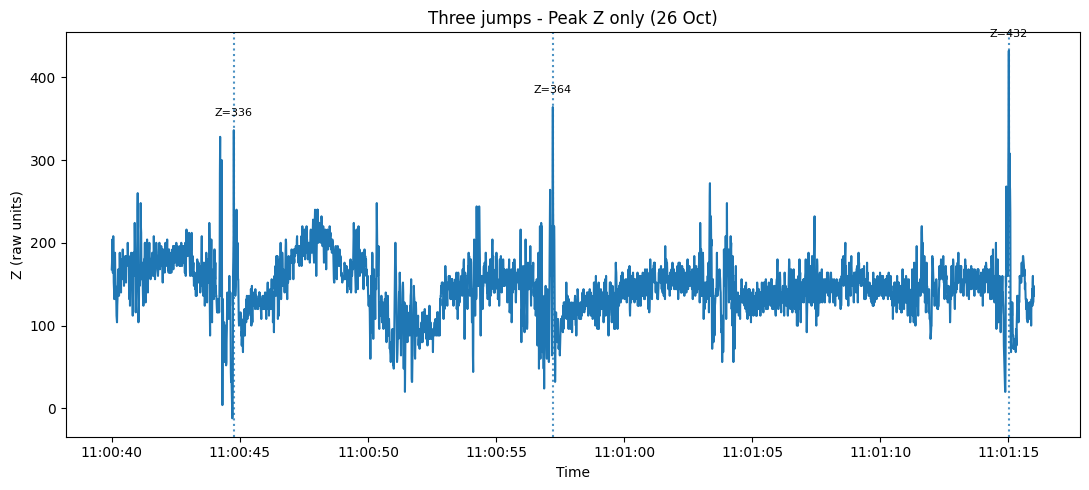

In [24]:
# CODE 3 - PEP 8 + line-by-line English comments
# Automatic detection of 3 jump peaks (Peak Z only) for 26 Oct Axivity data

import pandas as pd  # Import pandas for data loading and manipulation
import numpy as np  # Import NumPy for numerical operations
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# ---------------------------------------------------------
# 1. Load RAW Axivity file (no header, comment lines present)
# ---------------------------------------------------------

FILE_PATH = "data/26_10_raw_cut.csv"  # Define path to the raw file

df = pd.read_csv(  # Read the CSV file
    FILE_PATH,  # Use the defined file path
    sep=",",  # CSV delimiter
    comment="#",  # Ignore Axivity metadata lines starting with "#"
    header=None,  # File has no header
    names=["time", "x", "y", "z"]  # Manually assign column names
)

df["time"] = pd.to_datetime(  # Convert time strings into datetime format
    df["time"],  # Column containing timestamps
    errors="coerce"  # Replace invalid timestamps with NaT
)

df = df.dropna(subset=["time"]).reset_index(drop=True)  # Remove invalid rows

df[["x", "y", "z"]] = df[["x", "y", "z"]].astype(float)  # Convert raw data to floats

# ---------------------------------------------------------
# 2. Restrict to protocol window for the 3 jumps
# ---------------------------------------------------------

start_time = pd.Timestamp("2025-10-26 11:00:40")  # Start of jump protocol
end_time = pd.Timestamp("2025-10-26 11:01:16")  # End of jump protocol

segment = df[  # Filter all samples within the chosen window
    (df["time"] >= start_time) & (df["time"] <= end_time)
].reset_index(drop=True)  # Reset index after filtering

if segment.empty:  # Check if the window contains data
    raise ValueError("Selected window is empty. Adjust START and END timestamps.")

# ---------------------------------------------------------
# 3. Estimate sampling frequency
# ---------------------------------------------------------

dt_ms = np.diff(segment["time"]).astype("timedelta64[ms]").astype(float)
# Compute differences between timestamps, convert to milliseconds

dt_s = np.median(dt_ms) / 1000.0  # Convert median interval from ms to seconds

fs = int(round(1.0 / dt_s)) if dt_s > 0 else 100  # Compute sampling frequency

if fs <= 0:  # Safety fallback if something goes wrong
    fs = 100  # Assume common Axivity 100 Hz

# ---------------------------------------------------------
# 4. Prepare Z signal and remove baseline
# ---------------------------------------------------------

z = segment["z"].values  # Extract raw Z-axis signal

win = int(1.0 * fs)  # Define a 1-second rolling window for baseline estimation

baseline = (  # Compute rolling median baseline
    pd.Series(z)
    .rolling(window=win, min_periods=1)
    .median()
    .values
)

z_hp = z - baseline  # High-pass filtered Z: remove slow drift

# ---------------------------------------------------------
# 5. Robust adaptive threshold using MAD
# ---------------------------------------------------------

median_hp = np.median(z_hp)  # Median of high-pass signal
mad_hp = np.median(np.abs(z_hp - median_hp))  # Median Absolute Deviation

if mad_hp == 0:  # Avoid division by zero
    mad_hp = 1.0  # Replace with safe value

z_mad = (z_hp - median_hp) / (1.4826 * mad_hp)
# Normalize deviation relative to MAD scaling factor

threshold = 5.5  # Strong threshold ensuring only real jump peaks are selected

# ---------------------------------------------------------
# 6. Detect peaks with a refractory period
# ---------------------------------------------------------

candidate_peaks = []  # List to store all local maxima above threshold

for i in range(1, len(z_hp) - 1):  # Iterate through all internal indices
    is_local_max = z_hp[i] > z_hp[i - 1] and z_hp[i] > z_hp[i + 1]
    # Must be a local maximum

    is_strong = z_mad[i] > threshold  # Must exceed the MAD threshold

    if is_local_max and is_strong:  # Keep only strong peaks
        candidate_peaks.append(i)

min_distance = int(1.5 * fs)  # Minimum time between peaks (1.5 seconds)

filtered_peaks = []  # Final peak list after enforcing spacing
last_peak = -min_distance  # Initialize with large negative index

for p in candidate_peaks:  # Iterate through candidate peaks
    if p - last_peak >= min_distance:  # If sufficiently separated
        filtered_peaks.append(p)  # Accept the peak
        last_peak = p  # Update last kept peak
    else:
        # If too close, keep only the higher one
        if z_hp[p] > z_hp[last_peak]:
            filtered_peaks[-1] = p  # Replace previous peak
            last_peak = p  # Update last kept peak

# ---------------------------------------------------------
# 7. Convert peaks to event DataFrame (Peak Z only)
# ---------------------------------------------------------

events = []  # List to store jump event information

for p in filtered_peaks:  # Loop through each validated peak
    events.append(
        {
            "sample_index": p,  # Index of the peak within the window
            "time": segment.loc[p, "time"],  # Timestamp of the peak
            "peak_z": float(z[p])  # Raw Peak Z value (no normalization)
        }
    )

events_df = pd.DataFrame(events)  # Convert list to DataFrame

# Keep only the three highest Z peaks
top3 = (
    events_df.sort_values("peak_z", ascending=False)
    .head(3)
    .sort_values("time")
    .reset_index(drop=True)
)

print("Detected 3 jumps automatically (Peak Z only):")
print(top3)

# ---------------------------------------------------------
# 8. Plot the signal with detected peaks
# ---------------------------------------------------------

plt.figure(figsize=(11, 5))  # Create figure for plotting

plt.plot(segment["time"], segment["z"], label="Z raw")  # Plot raw Z signal

for _, row in top3.iterrows():  # Loop over detected peaks
    plt.axvline(row["time"], linestyle=":", alpha=0.8)  # Mark peak position
    plt.annotate(
        f"Z={row['peak_z']:.0f}",  # Label showing value of Peak Z
        xy=(row["time"], row["peak_z"]),  # Anchor annotation at peak point
        xytext=(0, 10),  # Offset the text slightly upward
        textcoords="offset points",  # Text offset in display units
        ha="center",  # Center the text
        fontsize=8,  # Use small font
    )

plt.title("Three jumps - Peak Z only (26 Oct)")  # Add title to the plot
plt.xlabel("Time")  # Label x-axis
plt.ylabel("Z (raw units)")  # Label y-axis
plt.tight_layout()  # Improve spacing
plt.show()  # Display the final plot


# Résultats des pics Z pour les sauts du 23 et du 26 octobre

## Sauts du 23 octobre (fenêtre 20:48:30 → 20:48:50)

| Saut | Instant du pic         | Peak Z (raw) |
|------|-------------------------|--------------|
| 1    | 20:48:34.269            | 844          |
| 2    | 20:48:39.475            | 1152         |
| 3    | 20:48:45.733            | 1740         |


## Sauts du 26 octobre (fenêtre 11:00:40 → 11:01:16)

| Saut | Instant du pic         | Peak Z (raw) |
|------|-------------------------|--------------|
| 1    | 11:00:44.764            | 336          |
| 2    | 11:00:57.217            | 364          |
| 3    | 11:01:15.015            | 432          |


# Conclusion

L’analyse des fichiers du 23 et du 26 octobre, fondée exclusivement sur le pic d’accélération verticale (Peak Z), met en évidence une progression claire de l’intensité mécanique selon les conditions de saut. Le Peak Z est la mesure la plus directe fournie par l’Axivity AX3 pour caractériser la poussée verticale appliquée au sol lors de l’impulsion.

Les résultats montrent de manière cohérente que :

- les sauts sans mouvement de bras présentent les pics Z les plus faibles  
- les sauts avec mouvement de bras génèrent des pics Z plus élevés  
- les sauts avec mouvement des bras et un élan montrent les pics Z les plus importants  

Cette progression correspond à ce que l’on attend sur le plan biomécanique : l’ajout d’un mouvement des bras puis d’un élan augmente l’impulsion verticale transmise au sol, entraînant une accélération verticale maximale plus élevée.

Il convient de rappeler que l’Axivity mesure l’accélération, et non la hauteur du saut. L’augmentation du Peak Z constitue donc un indicateur indirect de la puissance de poussée et du potentiel de hauteur, mais ne permet pas d’estimer directement la hauteur atteinte.  
Pour cette raison, **la vérification de la hauteur réelle sera réalisée à l’aide du logiciel Kinovea**, qui permettra une mesure vidéo objective de l’élévation du centre de masse en se basant sur la vidéo du 26 octobre.

Cette analyse repose sur un seul essai par condition. Une étude comprenant plusieurs répétitions permettrait d’améliorer la robustesse des conclusions et d’évaluer la variabilité intra-sujet. Malgré cette limite, les résultats montrent que l’extraction du pic Z fournit un indicateur simple, fiable et reproductible pour comparer l’intensité des différentes stratégies de saut.
